In [1]:
from model.DRST import DRST

import os
import warnings
import pandas as pd
from pathlib import Path

from sklearn import tree, metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
current_dir = os.getcwd()
# Path('%s\\output\\%s\\%s' % (current_dir, model, pat)).mkdir(parents=True, exist_ok=True)
# file1 = open('%s\\output\\%s\\%s\\result.txt' % (current_dir, model, pat), 'w+')

In [21]:
datasets = {
    'Health Insurance': {
        'path': 'datasets\\_old.csv',
        'outputPath': 'output\\Health Insurance',
        'nameregex': 'health_insurance',
        'dataset_size': 'normal',
        'class_name': 'class',
    },
    'D2': {
        'path': 'datasets\\d2wa.csv',
        'outputPath': 'output\\D2',
        'nameregex': 'd2',
        'dataset_size': 'normal',
        'class_name': 'fraud_reported',
    },
    }

datasets_names = list(datasets.keys())
test_ration = {'20-80': [20, 80], '30-70': [30, 70], '40-60': [40, 60]}

In [22]:
ex_c_c = ['Annual_Premium', 'Vintage', 'Age']
def encoder(d):
    le = LabelEncoder()
    encoder_dict = dict()
    data_endocded = d.copy()

    for col in data_endocded:
        if col not in ex_c_c:
            le = le.fit(data_endocded[col])
            data_endocded[col] = le.transform(data_endocded[col])
            encoder_dict[col] = le
    return data_endocded

In [47]:

data = pd.read_csv(datasets['Health Insurance']['path'])
df = data.copy()
df = df.sample(1000, random_state=41) # 41
df.drop(['Vintage', 'Age'], axis=1, inplace=True)
Path('%s\\%s' % (current_dir, datasets['Health Insurance']['outputPath'])).mkdir(parents=True, exist_ok=True)

drst = DRST(comb_max_depth=1, decision_column_name='Response', output_loction=datasets['Health Insurance']['outputPath'])
drst_fit, continuous_columns = drst.fit(df, ensamble_threshold=0.9, continous_columns=['Annual_Premium'])
drst_fit.drop(continuous_columns, axis=1, inplace=True)

datasets['Health Insurance'].update({
    'drop_column': ['Vintage', 'Age'],
    'class_name': 'Response',
    'data': df,
    'data_original': encoder(df),
    'data_drst': drst_fit
    })

Annual_Premium    3
dtype: int64


In [39]:
datasets['Health Insurance']['data_drst']

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
7542,1,24,1,45,1,1,0,29654.0,35,115,0
7716,0,33,1,32,1,1,0,33054.0,35,36,0
89071,1,53,1,28,0,2,1,69040.0,28,245,1
71895,0,40,1,28,0,0,1,2630.0,15,164,1
1979,1,25,1,29,1,1,0,22147.0,35,43,0
...,...,...,...,...,...,...,...,...,...,...,...
977,1,65,1,41,1,0,0,29016.0,27,235,0
93013,1,52,1,8,0,0,1,48250.0,15,114,1
25612,1,30,1,41,1,1,0,32108.0,15,192,0
65735,1,22,1,28,0,1,1,51296.0,29,230,1


In [48]:
D2 = pd.read_csv(datasets['D2']['path'])
D2.drop(['months_as_customer', 'age', 'total_claim_amount'], axis=1, inplace=True)
drst1 = DRST(comb_max_depth=1, decision_column_name='fraud_reported', output_loction=datasets['D2']['outputPath'])
drst_fit1, continuous_columns= drst1.fit(D2, continous_columns=['policy_annual_premium'])
drst_fit1['policy_annual_premium'] = drst_fit1['policy_annual_premium_AFTER']
drst_fit1.drop('policy_annual_premium_AFTER', axis=1, inplace=True)

datasets['D2'].update({
            'drop_column': [],
            'data': D2,'data_original': encoder(D2),
            'data_drst': drst_fit1
            })

policy_annual_premium    7
dtype: int64


In [49]:
def Test_RFC(test_name, test_split='20-80', print_flag=False):
    '''
        test_split is the percentage of the splitting for the data, which train_split =  100 - test_split
    '''
    for mode in ['data_original', 'data_drst']:
        # Scraping info of dataset from datasets variable
        data = datasets[test_name][mode].copy()
        class_name = datasets[test_name]['class_name']
        regex_name = datasets[test_name]['nameregex']
        
        file = open('%s\\output\\accuracy_result.text' % (current_dir), 'a+')
        
        Path('%s\\output\\%s\\RandomForestClassifier\\%s' % (current_dir, test_name, test_split)).mkdir(parents=True, exist_ok=True)

        feature_names = [i for i in data.columns if i != class_name]
        X, y = data[feature_names], data[class_name]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ration[test_split][0]/100, random_state=0)
        # clf = RandomForestClassifier(max_depth=2, random_state=0)
        clf = RandomForestClassifier(n_estimators = 100, random_state=21) 
        
        # Training the model on the training dataset
        # fit function is used to train the model using the training sets as parameters
        clf.fit(X_train, y_train)
        
        # performing predictions on the test dataset
        y_pred = clf.predict(X_test)
        
        # metrics are used to find accuracy or error
        report = classification_report(y_test, y_pred, output_dict=True)
        report.update({'Rules Number': len(tree.export_text(clf.estimators_[0]))})
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv('%s\\output\\%s\\RandomForestClassifier\\%s\\report-CLFTester-%s-%s.csv' % (current_dir, test_name, test_split, regex_name, mode))
        file.write("data %s:ACCURACY for data %s in model RandomForestClassifier with split ration %s === %s\n" % (test_name,mode,test_split,metrics.accuracy_score(y_test, y_pred)))
        if print_flag:
            # using metrics module for accuracy calculation
            print('------------------------')
            print(test_name)
            print('------------------------')
            print("Number of rules Extracted from the model: %s" % len(tree.export_text(clf.estimators_[0])))
            print("ACCURACY: %s" % (metrics.accuracy_score(y_test, y_pred)))
            print("CLASSIFICATION REPORT \n %s" % report)

        tree.plot_tree(clf.estimators_[0],
                    feature_names = feature_names, 
                    class_names=class_name,
                    filled = True)
        plt.savefig('%s\\output\\%s\\RandomForestClassifier\\%s\\CLFTester-%s-%s.png' % (current_dir, test_name, test_split, regex_name, mode))
        plt.close()
    file.write('\n')
    file.close()

Path('%s\\output\\accuracy_result.text' % (current_dir)).touch(exist_ok=True)
file = open('%s\\output\\accuracy_result.text' % (current_dir), 'a+')
file.write('___________________________________________________\n')
file.write('All RandomForestClassifier Results\n')
file.write('___________________________________________________\n')
file.close()
for tp in test_ration.keys():
    Test_RFC(datasets_names[0], test_split=tp)
    Test_RFC(datasets_names[1], test_split=tp)
    

In [50]:
def Test_DT(test_name, test_split='20-80', print_flag=False):
    '''
        test_split is the percentage of the splitting for the data, which train_split =  100 - test_split
    '''
    for mode in ['data_original', 'data_drst']:
        # Scraping info of dataset from datasets variable
        data = datasets[test_name][mode].copy()
        class_name = datasets[test_name]['class_name']
        regex_name = datasets[test_name]['nameregex']

        Path('%s\\output\\accuracy_result.text' % (current_dir)).touch(exist_ok=True)
        file = open('%s\\output\\accuracy_result.text' % (current_dir), 'a+')
        Path('%s\\output\\%s\\DecisionTrees\\%s' % (current_dir, test_name, test_split)).mkdir(parents=True, exist_ok=True)

        feature_names = [i for i in data.columns if i != class_name]
        X, y = data[feature_names], data[class_name]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ration[test_split][0]/100, random_state=1)
        clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='random')
        
        # Training the model on the training dataset
        # fit function is used to train the model using the training sets as parameters
        clf.fit(X_train, y_train)
        
        # performing predictions on the test dataset
        y_pred = clf.predict(X_test)
        
        # metrics are used to find accuracy or error
        report = classification_report(y_test, y_pred, output_dict=True)
        report.update({'Rules Number': len(tree.export_text(clf))})
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv('%s\\output\\%s\\DecisionTrees\\%s\\report-CLFTester-%s-%s.csv' % (current_dir, test_name, test_split, regex_name, mode))
        file.write("data %s:ACCURACY for data %s in model DecisionTrees with split ration %s === %s\n" % (test_name,mode,test_split,metrics.accuracy_score(y_test, y_pred)))
        if print_flag:
            # using metrics module for accuracy calculation
            print('------------------------')
            print(test_name)
            print('------------------------')
            print("Number of rules Extracted from the model: %s" % len(tree.export_text(clf.estimators_[0])))
            print("ACCURACY: %s" % (metrics.accuracy_score(y_test, y_pred)))
            print("CLASSIFICATION REPORT \n %s" % report)

        tree.plot_tree(clf,
                    feature_names = feature_names, 
                    class_names=class_name,
                    filled = True)
        plt.savefig('%s\\output\\%s\\DecisionTrees\\%s\\CLFTester-%s-%s.png' % (current_dir, test_name, test_split, regex_name, mode))
        plt.close()
    file.write('\n')
    file.close()

Path('%s\\output\\accuracy_result.text' % (current_dir)).touch(exist_ok=True)
file = open('%s\\output\\accuracy_result.text' % (current_dir), 'a+')
file.write('___________________________________________________\n')
file.write('All DecisionTrees Results\n')
file.write('___________________________________________________\n')
file.close()
for tp in test_ration.keys():
    Test_DT(datasets_names[0], test_split=tp)
    Test_DT(datasets_names[1], test_split=tp)

In [51]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

def Test_XG(test_name, test_split='20-80', print_flag=False):
    '''
        test_split is the percentage of the splitting for the data, which train_split =  100 - test_split
    '''
    for mode in ['data_original', 'data_drst']:
        # Scraping info of dataset from datasets variable
        data = datasets[test_name][mode].copy()
        class_name = datasets[test_name]['class_name']
        regex_name = datasets[test_name]['nameregex']

        Path('%s\\output\\accuracy_result.text' % (current_dir)).touch(exist_ok=True)
        file = open('%s\\output\\accuracy_result.text' % (current_dir), 'a+')
        Path('%s\\output\\%s\\XGBRFClassifier\\%s' % (current_dir, test_name, test_split)).mkdir(parents=True, exist_ok=True)

        feature_names = [i for i in data.columns if i != class_name]
        X, y = data[feature_names], data[class_name]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ration[test_split][0]/100, random_state=24)
        xg_reg = xgb.XGBRFClassifier()
        # Training the model on the training dataset
        # fit function is used to train the model using the training sets as parameters
        xg_reg.fit(X_train,y_train)
        # performing predictions on the test dataset
        y_pred = xg_reg.predict(X_test)
        
        # # metrics are used to find accuracy or error
        report = classification_report(y_test, y_pred, output_dict=True)
        report.update({'Rules Number': xg_reg._Booster.trees_to_dataframe().shape[0]})
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv('%s\\output\\%s\\XGBRFClassifier\\%s\\report-CLFTester-%s-%s.csv' % (current_dir, test_name, test_split, regex_name, mode))
        file.write("data %s:ACCURACY for data %s in model XGBRFClassifier with split ration %s === %s\n" % (test_name,mode,test_split,metrics.accuracy_score(y_test, y_pred)))
        if print_flag:
            # using metrics module for accuracy calculation
            print('------------------------')
            print(test_name)
            print('------------------------')
            print("Number of rules Extracted from the model: %s" % len(tree.export_text(xg_reg._Booster.trees_to_dataframe().shape[0])))
            print("ACCURACY: %s" % (metrics.accuracy_score(y_test, y_pred)))
            print("CLASSIFICATION REPORT \n %s" % report)
        
        fig, ax = plt.subplots(figsize=(30, 30))
        xgb.plot_tree(xg_reg, num_trees=4, ax=ax)
        # tree.plot_tree(clf,
        #             feature_names = feature_names, 
        #             class_names=class_name,
        #             filled = True)
        plt.savefig('%s\\output\\%s\\XGBRFClassifier\\%s\\CLFTester-%s-%s.png' % (current_dir, test_name, test_split, regex_name, mode))
        plt.close()
    file.write('\n')
    file.close()

Path('%s\\output\\accuracy_result.text' % (current_dir)).touch(exist_ok=True)
file = open('%s\\output\\accuracy_result.text' % (current_dir), 'a+')
file.write('___________________________________________________\n')
file.write('All XGBRFClassifier Results\n')
file.write('___________________________________________________\n')
file.close()
for tp in test_ration.keys():
    Test_XG(datasets_names[0], test_split=tp)
    Test_XG(datasets_names[1], test_split=tp)

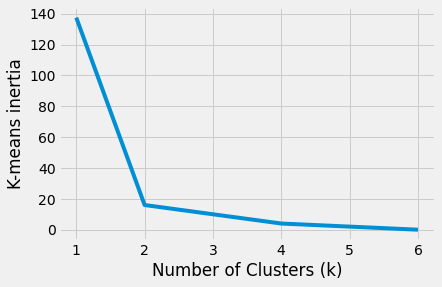

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
range_n_clusters = [1, 2, 3, 4, 5, 6]
avg_distance=[]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    avg_distance.append(clusterer.inertia_)

style.use("fivethirtyeight")
plt.plot(range_n_clusters, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("K-means inertia")
plt.show()